In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Let's load the data

In [139]:
def get_yearly_flow(year=2016):
    """ Reading text files with yearly data.
    """
    flow_df = pd.read_csv(f'data/hourly_flows_2016-19/flows-{year}.txt', delimiter='\t').drop(columns='V')
    flow_df.columns = ['datetime', 'discharge']
    flow_df['datetime'] = pd.to_datetime(flow_df['datetime'])
    flow_df = flow_df.set_index('datetime')
    return flow_df

In [150]:
def get_combined_flow():
    """ Combining dataframes from individual years into one dataframe.
    """
    dfs = []
    for year in range(2016, 2020):
        dfs.append(get_yearly_flow(year=year))
    return pd.concat(dfs)
        

In [151]:
flow_df = get_combined_flow()

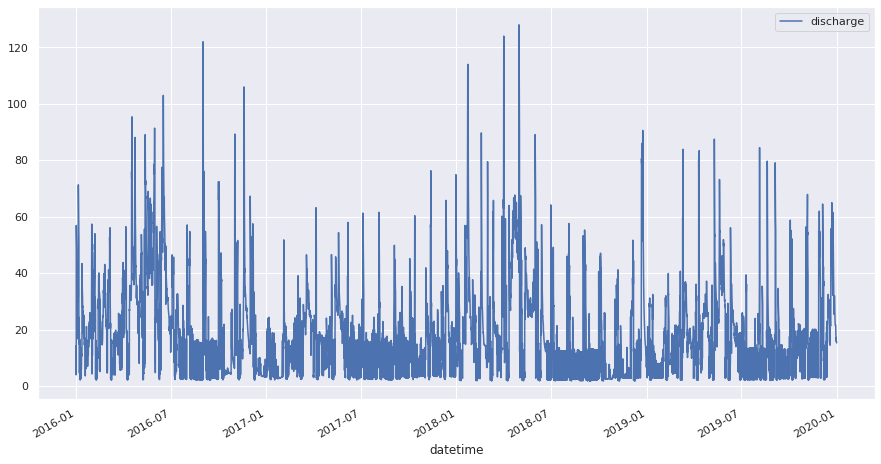

In [152]:
flow_df.plot()

In [153]:
flow_df.to_csv('data/hourly_flows_2016-19.csv')

### Exploratory Analysis

In [154]:
subset_df = flow_df.loc[:]
subset_df['year'] = subset_df.index.year
subset_df['offset_datetime'] = subset_df.index + pd.DateOffset(year=2019)

/home/mnolte/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:692: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


In [168]:
sns.set(style="whitegrid")

Text(0, 0.5, 'Discharge (m^3/s)')

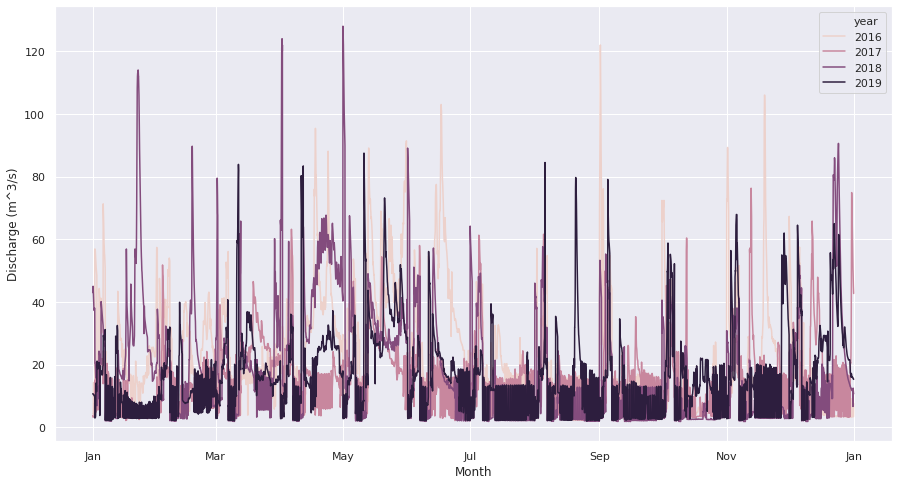

In [169]:
sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.lineplot(x='offset_datetime', y='discharge', hue='year', data=subset_df, markers='')
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')
ax.get_xaxis().set_major_formatter(myFmt)
ax.set_xlabel('Month')
ax.set_ylabel('Discharge (m^3/s)')

In [160]:
flow_df

,discharge
datetime,
2016-01-01 00:00:00,4.31
2016-01-01 01:00:00,4.32
2016-01-01 02:00:00,4.33
2016-01-01 03:00:00,4.34
2016-01-01 04:00:00,4.35
...,...
2019-12-31 18:00:00,15.50
2019-12-31 19:00:00,15.50
2019-12-31 20:00:00,15.40
